In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu

import quimb.tensor as qtn

/Users/trongduong/opt/anaconda3/envs/qosf/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [3]:
L = 300
D = 16
pbc = True
# create a random MPS as our initial target to optimize
psi = qtn.MPS_rand_state(L, bond_dim=D, cyclic=pbc)

# create the hamiltonian MPO, this is a constant TN not to be optimized
ham = qtn.MPO_ham_ising(L, j=1.0, bx=1.0, cyclic=pbc)

In [5]:
def norm_fn(psi):
    # we could always define this within the loss function, but separating it
    # out can be clearer - it's also called before returning the optimized TN
    nfact = (psi.H @ psi)**0.5
    return psi.multiply(1 / nfact, spread_over='all')


def loss_fn(psi, ham):
    b, h, k = qtn.tensor_network_align(psi.H, ham, psi)
    energy_tn = b | h | k
    return energy_tn ^ ...

In [7]:
loss_fn(norm_fn(psi), ham)

-0.5858017597535812

In [8]:
tnopt = qtn.TNOptimizer(
    psi,
    loss_fn=loss_fn,
    norm_fn=norm_fn,
    loss_constants={"ham": ham},
    optimizer="adam",
    #autodiff_backend="jax",
)
tnopt

<TNOptimizer(d=153600, backend=jax)>

In [39]:
psi_opt = tnopt.optimize(1000)

-34.029705047607 [best: -34.029911041260] : : 1001it [02:10,  7.69it/s]         


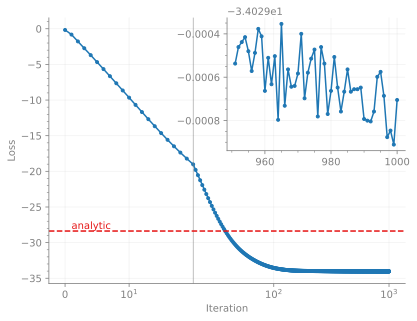

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Iteration', ylabel='Loss'>)

In [42]:
tnopt.plot(hlines={'analytic': qu.heisenberg_energy(L)})

In [162]:
help(qtn.DMRG2)

Help on class DMRG2 in module quimb.tensor.tensor_dmrg:

class DMRG2(DMRG)
 |  DMRG2(ham, which='SA', bond_dims=None, cutoffs=1e-08, p0=None)
 |
 |  Simple alias of two site ``DMRG``.Density Matrix Renormalization Group variational groundstate search.
 |  Some initialising arguments act as defaults, but can be overidden with
 |  each solve or sweep. See :func:`~quimb.tensor.tensor_dmrg.get_default_opts`
 |  for the list of advanced options initialized in the ``opts`` attribute.
 |
 |  Parameters
 |  ----------
 |  ham : MatrixProductOperator
 |      The hamiltonian in MPO form.
 |  bond_dims : int or sequence of ints.
 |      The bond-dimension of the MPS to optimize. If ``bsz > 1``, then this
 |      corresponds to the maximum bond dimension when splitting the effective
 |      local groundstate. If a sequence is supplied then successive sweeps
 |      iterate through, then repeate the final value. E.g.
 |      ``[16, 32, 64] -> (16, 32, 64, 64, 64, ...)``.
 |  cutoffs : dict-like
 | 

In [164]:
dmrg = qtn.DMRG2(ham, bond_dims=[16, 32, 64, 128, 256, 512, 1024])

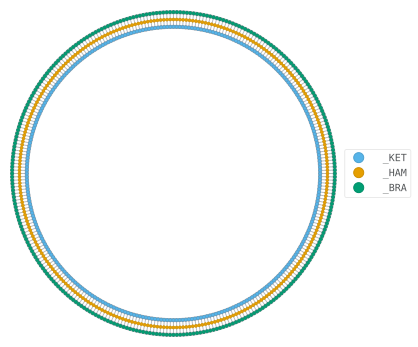

In [166]:
from cmath import exp, pi
fix = {
    **{(f'I{i}', '_KET'): (100 * exp(2j*pi * i / L).real, 100 * exp(2j*pi * i / L).imag) for i in range(L)},
    **{(f'I{i}', '_HAM'): (105 * exp(2j*pi * i / L).real, 105 * exp(2j*pi * i / L).imag) for i in range(L)},
    **{(f'I{i}', '_BRA'): (110 * exp(2j*pi * i / L).real, 110 * exp(2j*pi * i / L).imag) for i in range(L)},
}
dmrg.TN_energy.draw(color=['_KET', '_HAM', '_BRA'], fix=fix, iterations=0)

In [76]:
help(dmrg.solve)

Help on method solve in module quimb.tensor.tensor_dmrg:

solve(tol=0.0001, bond_dims=None, cutoffs=None, sweep_sequence=None, max_sweeps=10, verbosity=0, suppress_warnings=True) method of quimb.tensor.tensor_dmrg.DMRG2 instance
    Solve the system with a sequence of sweeps, up to a certain
    absolute tolerance in the energy or maximum number of sweeps.

    Parameters
    ----------
    tol : float, optional
        The absolute tolerance to converge energy to.
    bond_dims : int or sequence of int
        Overide the initial/current bond_dim sequence.
    cutoffs : float of sequence of float
        Overide the initial/current cutoff sequence.
    sweep_sequence : str, optional
        String made of 'L' and 'R' defining the sweep sequence, e.g 'RRL'.
        The sequence will be repeated until ``max_sweeps`` is reached.
    max_sweeps : int, optional
        The maximum number of sweeps to perform.
    verbosity : {0, 1, 2}, optional
        How much information to print about p

In [168]:
dmrg.solve(max_sweeps=10, verbosity=1, cutoffs=1e-6)

1, R, max_bond=(16/16), cutoff:1e-06


100%|#########################################| 300/300 [00:06<00:00, 44.22it/s]

Energy: -16.08050227755686 ... not converged.
2, R, max_bond=(16/32), cutoff:1e-06



100%|#########################################| 300/300 [00:08<00:00, 34.01it/s]

Energy: -159.5314015794427 ... not converged.
3, R, max_bond=(32/64), cutoff:1e-06



100%|#########################################| 300/300 [00:06<00:00, 49.39it/s]

Energy: -0.3717644374798303 ... not converged.
4, R, max_bond=(34/128), cutoff:1e-06



100%|#########################################| 300/300 [00:05<00:00, 52.07it/s]

Energy: -0.449138789913196 ... not converged.
5, R, max_bond=(44/256), cutoff:1e-06



100%|#########################################| 300/300 [00:06<00:00, 46.06it/s]

Energy: -158.77864089583034 ... not converged.
6, R, max_bond=(53/512), cutoff:1e-06



100%|#########################################| 300/300 [00:06<00:00, 43.64it/s]

Energy: -158.77864131427492 ... converged!


True

In [170]:
gs = dmrg.state
gs.max_bond()

63

In [172]:
dmrg.energy

-158.77864131427492